In [3]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
DATASET_PATH = "/kaggle/input/lung-cancer-histopathological-images"

In [5]:
WORKING_DIR = "/kaggle/working/dataset"
if not os.path.exists(WORKING_DIR):
    shutil.copytree(DATASET_PATH, WORKING_DIR)

In [6]:
classes = ["adenocarcinoma", "benign", "squamous_cell_carcinoma"]

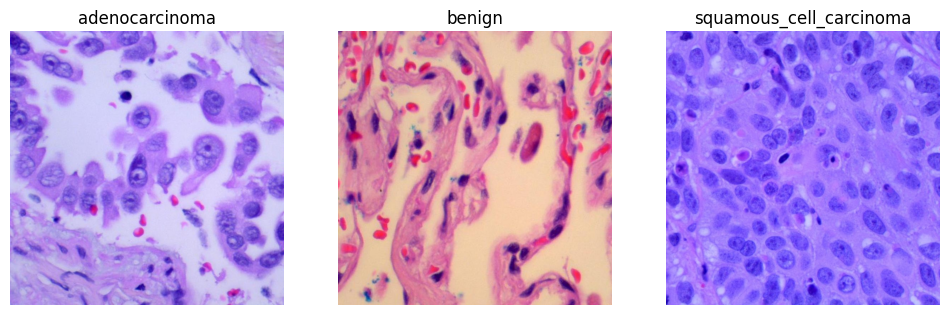

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate(classes):
    img_path = os.path.join(WORKING_DIR, label)
    img_file = random.choice(os.listdir(img_path))
    img = cv2.imread(os.path.join(img_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show()


In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# Create ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training data
train_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

# Load DenseNet121 base model
base_model = tf.keras.applications.DenseNet121(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
base_model.trainable = False

# Add custom head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-5)),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # Adjust to your number of classes
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,169,091 (27.35 MB)

 Trainable params: 131,587 (514.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744402915.580942     393 service.cc:148] XLA service 0x78d81c002650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744402915.580993     393 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744402915.581003     393 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744402918.275999     393 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/188 ━━━━━━━━━━━━━━━━━━━━ 2:10:20 42s/step - accuracy: 0.3594 - loss: 1.3791

I0000 00:00:1744402933.251676     393 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.6746 - loss: 0.7358 - val_accuracy: 0.9107 - val_loss: 0.2637 - learning_rate: 1.0000e-04
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9018 - loss: 0.2681 - val_accuracy: 0.9293 - val_loss: 0.1945 - learning_rate: 1.0000e-04
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9224 - loss: 0.2051 - val_accuracy: 0.9413 - val_loss: 0.1702 - learning_rate: 1.0000e-04
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9329 - loss: 0.1789 - val_accuracy: 0.9373 - val_loss: 0.1610 - learning_rate: 1.0000e-04
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9316 - loss: 0.1700 - val_accuracy: 0.9477 - val_loss: 0.1477 - learning_rate: 1.0000e-04
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9404 - loss: 0.1560 - val_accuracy: 0.9457 - val_loss: 0.1414 - learning_rate: 1.0000e-04
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.94

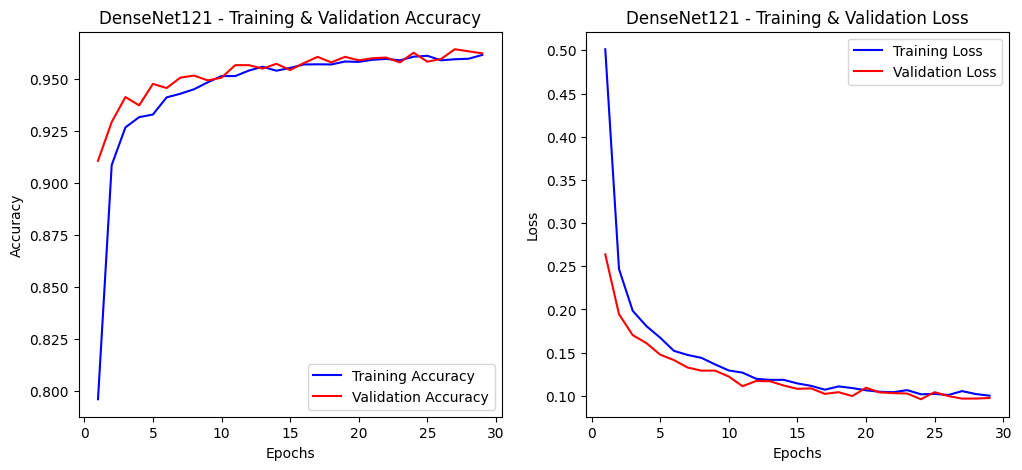

DenseNet121 model saved.


In [11]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('DenseNet121 - Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DenseNet121 - Training & Validation Loss')
plt.legend()

plt.show()

# Save model
model.save('/kaggle/working/resnet50_lung_cancer.h5')
print("DenseNet121 model saved.")
